# Load Dataset

In [1]:
import os

# Set dataset root
dataset_root = '/kaggle/input/aebad-s/AeBAD_S'

test_dir = os.path.join(dataset_root, 'test')
gt_dir = os.path.join(dataset_root, 'ground_truth')

# Multi-class labels
label_map = {
    'good': 0,
    'ablation': 1,
    'breakdown': 2,
    'fracture': 3,
    'groove': 4,
}

image_paths = []
labels = []
label_names = []

# Walk through each class
for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)
    
    if not os.path.isdir(cls_path):
        continue

    for root, _, files in os.walk(cls_path):
        for file in files:
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                continue

            img_full_path = os.path.join(root, file)

            # Default label is 0 (good)
            label = 0
            label_name = 'good'

            if cls != 'good':
                # Build corresponding ground truth mask path
                rel_path = os.path.relpath(img_full_path, test_dir)
                mask_path = os.path.join(gt_dir, rel_path)

                # Handle possible suffix differences (_mask)
                mask_dir = os.path.dirname(mask_path)
                mask_file_base = os.path.splitext(os.path.basename(file))[0]
                
                # Check multiple formats
                mask_found = False
                for ext in ['.png', '.jpg', '.bmp', '.tif']:
                    possible_mask = os.path.join(mask_dir, mask_file_base + ext)
                    if os.path.exists(possible_mask):
                        mask_found = True
                        break
                    # Try with _mask suffix
                    possible_mask = os.path.join(mask_dir, mask_file_base + '_mask' + ext)
                    if os.path.exists(possible_mask):
                        mask_found = True
                        break

                if mask_found:
                    label = label_map[cls]
                    label_name = cls

            image_paths.append(img_full_path)
            labels.append(label)
            label_names.append(label_name)

print(f"Total images found: {len(image_paths)}")
for key, val in label_map.items():
    print(f"{key} --> Label: {val} --> Count: {labels.count(val)}")

# OPTIONAL: Print samples to double-check
for i in range(5):
    print(f"{image_paths[i]} --> Label: {labels[i]} ({label_names[i]})")

Total images found: 1639
good --> Label: 0 --> Count: 490
ablation --> Label: 1 --> Count: 169
breakdown --> Label: 2 --> Count: 329
fracture --> Label: 3 --> Count: 389
groove --> Label: 4 --> Count: 262
/kaggle/input/aebad-s/AeBAD_S/test/ablation/illumination/IMG_8907.png --> Label: 1 (ablation)
/kaggle/input/aebad-s/AeBAD_S/test/ablation/illumination/IMG_8904.png --> Label: 1 (ablation)
/kaggle/input/aebad-s/AeBAD_S/test/ablation/illumination/IMG_8889.png --> Label: 1 (ablation)
/kaggle/input/aebad-s/AeBAD_S/test/ablation/illumination/IMG_8894.png --> Label: 1 (ablation)
/kaggle/input/aebad-s/AeBAD_S/test/ablation/illumination/IMG_8893.png --> Label: 1 (ablation)


# Show test images with ground truth


Label 0: good
Image path: /kaggle/input/aebad-s/AeBAD_S/test/good/illumination/IMG_7708.png


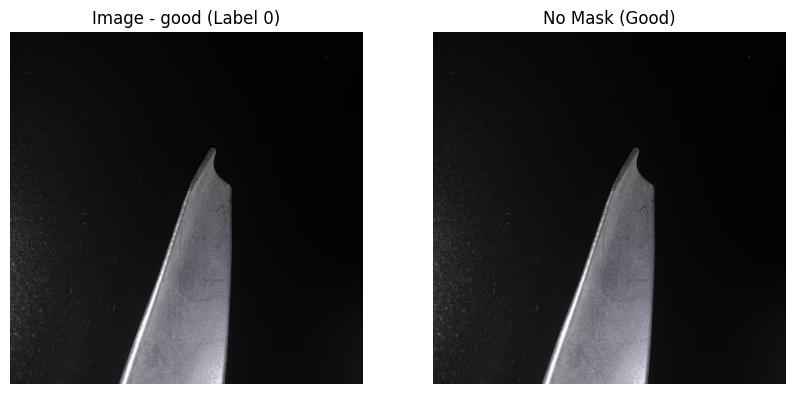


Label 1: ablation
Image path: /kaggle/input/aebad-s/AeBAD_S/test/ablation/illumination/IMG_8907.png


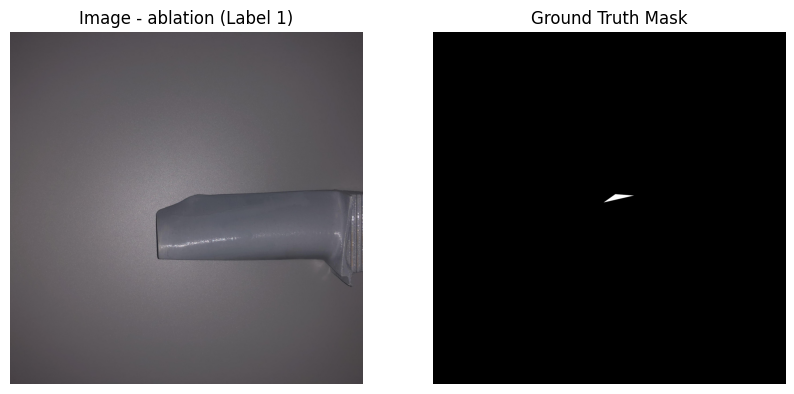


Label 2: breakdown
Image path: /kaggle/input/aebad-s/AeBAD_S/test/breakdown/illumination/IMG_9204.png


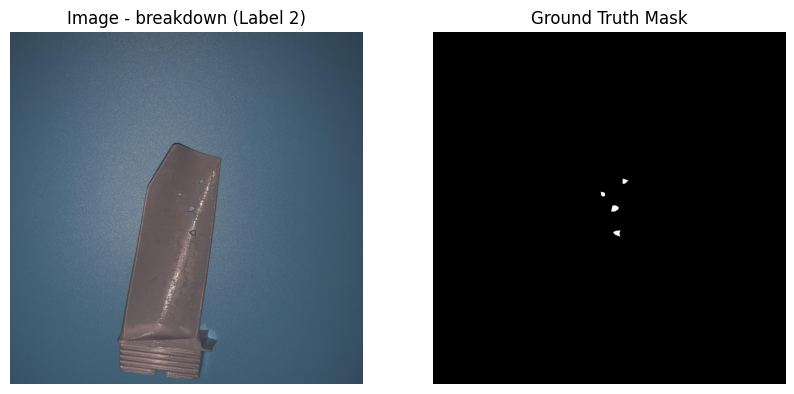


Label 3: fracture
Image path: /kaggle/input/aebad-s/AeBAD_S/test/fracture/illumination/IMG_9732.png


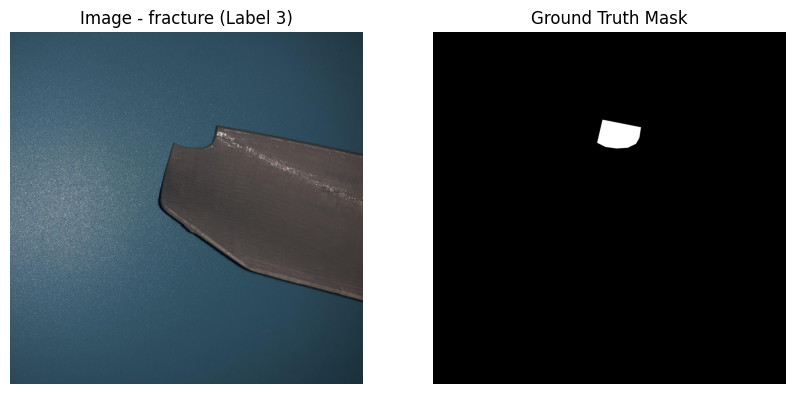


Label 4: groove
Image path: /kaggle/input/aebad-s/AeBAD_S/test/groove/illumination/IMG_8453.png


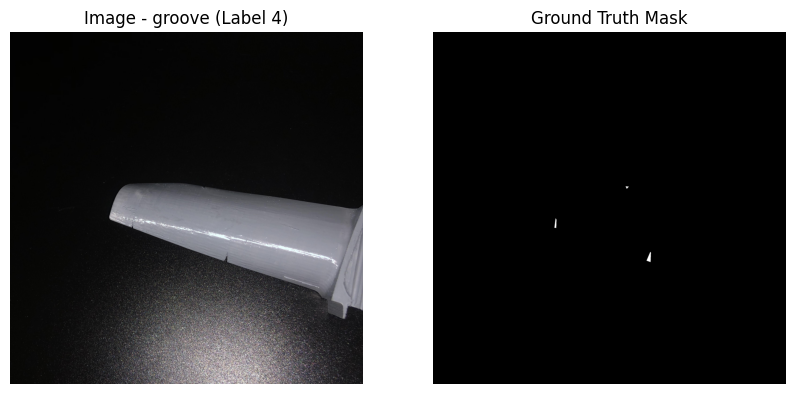

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Store first sample for each label (0 to 4)
first_samples = {}

# Loop through all images to find the first of each class
for img_path, label in zip(image_paths, labels):
    if label not in first_samples:
        first_samples[label] = img_path
    if len(first_samples) == len(label_map):  # Found all
        break

# Plot each sample with its mask
for label, img_path in sorted(first_samples.items()):
    cls_name = [name for name, lbl in label_map.items() if lbl == label][0]
    print(f"\nLabel {label}: {cls_name}")
    print(f"Image path: {img_path}")

    # Load image
    img = Image.open(img_path).convert('RGB')

    # Prepare mask (only if it's not good)
    mask = None
    if label != 0:
        rel_path = os.path.relpath(img_path, test_dir)
        mask_path = os.path.join(gt_dir, rel_path)

        mask_dir = os.path.dirname(mask_path)
        mask_file_base = os.path.splitext(os.path.basename(img_path))[0]

        # Look for mask with or without _mask suffix
        for ext in ['.png', '.jpg', '.bmp', '.tif']:
            possible_mask = os.path.join(mask_dir, mask_file_base + ext)
            if os.path.exists(possible_mask):
                mask = Image.open(possible_mask).convert('L')
                break
            possible_mask = os.path.join(mask_dir, mask_file_base + '_mask' + ext)
            if os.path.exists(possible_mask):
                mask = Image.open(possible_mask).convert('L')
                break

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title(f"Image - {cls_name} (Label {label})")
    axs[0].axis('off')

    if mask is not None:
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title(f"Ground Truth Mask")
    else:
        axs[1].imshow(img)  # Just repeat image if no mask (for good)
        axs[1].set_title("No Mask (Good)")

    axs[1].axis('off')
    plt.show()

 #  Part 3: Custom PyTorch Dataset & Transforms

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match pre-trained models
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset
class AeBADTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, label

 # Part 4: "Load Dataset and Create DataLoader"

In [4]:
from torch.utils.data import DataLoader

# Instantiate the dataset
test_dataset = AeBADTestDataset(image_paths, labels, transform=transform)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Part 5: Model Architecture using Transfer Learning (VGG16)

In [5]:
import torch
import torch.nn as nn
from torchvision import models

# Number of classes in AeBAD_S
NUM_CLASSES = 5

def get_vgg16_model(num_classes=NUM_CLASSES):
    # Load pre-trained VGG16
    model = models.vgg16(pretrained=True)

    # Freeze earlier layers if desired
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace the classifier head
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    return model

 # Part 6: Training Setup

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_vgg16_model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s]


# Part 7: Full Training Loop with multi-class support, accuracy, and loss tracking

In [7]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def train_model(model, train_loader, num_epochs=10, device='cuda'):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

# Call the Training Function

In [8]:
# Example: Wrap the images/labels you've already loaded
from torchvision import transforms
from PIL import Image
import torch

# Resize, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])   # ImageNet std
])

# Create tensors
image_tensors = []
label_tensors = []

for img_path, label in zip(image_paths, labels):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img)
    image_tensors.append(img_tensor)
    label_tensors.append(torch.tensor(label))

X = torch.stack(image_tensors)
y = torch.tensor(label_tensors)

# DataLoader
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Train the model
train_model(model, train_loader, num_epochs=1, device=device)

Epoch [1/1] - Loss: 0.8443 - Accuracy: 69.80%


# Part 8: Evaluation code with per-class accuracy and confusion matrix

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader, label_map, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    labels_list = [cls for cls, idx in sorted(label_map.items(), key=lambda x: x[1])]

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Detailed metrics
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=labels_list))

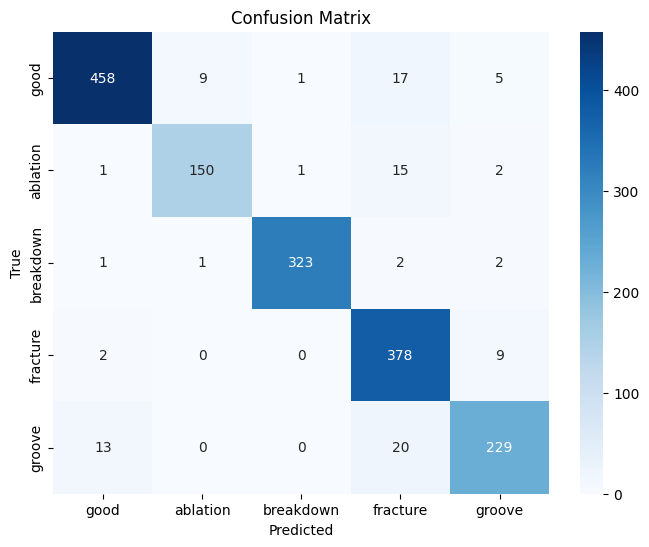


Classification Report:
              precision    recall  f1-score   support

        good       0.96      0.93      0.95       490
    ablation       0.94      0.89      0.91       169
   breakdown       0.99      0.98      0.99       329
    fracture       0.88      0.97      0.92       389
      groove       0.93      0.87      0.90       262

    accuracy                           0.94      1639
   macro avg       0.94      0.93      0.93      1639
weighted avg       0.94      0.94      0.94      1639



In [10]:
evaluate_model(model, train_loader, label_map, device=device)

# Part 9: Prediction + Visualization on Random Test Images for your multi-class anomaly detection setup

In [11]:
import random
from torchvision import transforms

def visualize_preds_with_gt_mask(model, image_paths, labels, label_map, device='cuda', num_samples=5):
    model.eval()
    inv_label_map = {v: k for k, v in label_map.items()}
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Choose random sample indices
    idxs = random.sample(range(len(image_paths)), num_samples)

    for i in idxs:
        img_path = image_paths[i]
        true_label = labels[i]
        true_class = inv_label_map[true_label]

        # Preprocess and predict
        img = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
        pred_label = pred.item()
        pred_class = inv_label_map[pred_label]

        # Load ground truth mask (if applicable)
        mask = None
        if true_label != 0:  # Not 'good'
            rel_path = os.path.relpath(img_path, test_dir)
            mask_path = os.path.join(gt_dir, rel_path)
            mask_dir = os.path.dirname(mask_path)
            mask_file_base = os.path.splitext(os.path.basename(img_path))[0]

            for ext in ['.png', '.jpg', '.bmp', '.tif']:
                for suffix in ['', '_mask']:
                    possible_mask = os.path.join(mask_dir, mask_file_base + suffix + ext)
                    if os.path.exists(possible_mask):
                        mask = Image.open(possible_mask).convert('L')
                        break
                if mask is not None:
                    break

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].imshow(img)
        axs[0].set_title(f"Pred: {pred_class} ({pred_label})", 
                         color='green' if pred_label == true_label else 'red')
        axs[0].axis('off')

        if mask is not None:
            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title(f"Ground Truth Mask - {true_class}")
        else:
            axs[1].imshow(img)
            axs[1].set_title("No Mask (Good)")

        axs[1].axis('off')
        plt.tight_layout()
        plt.show()

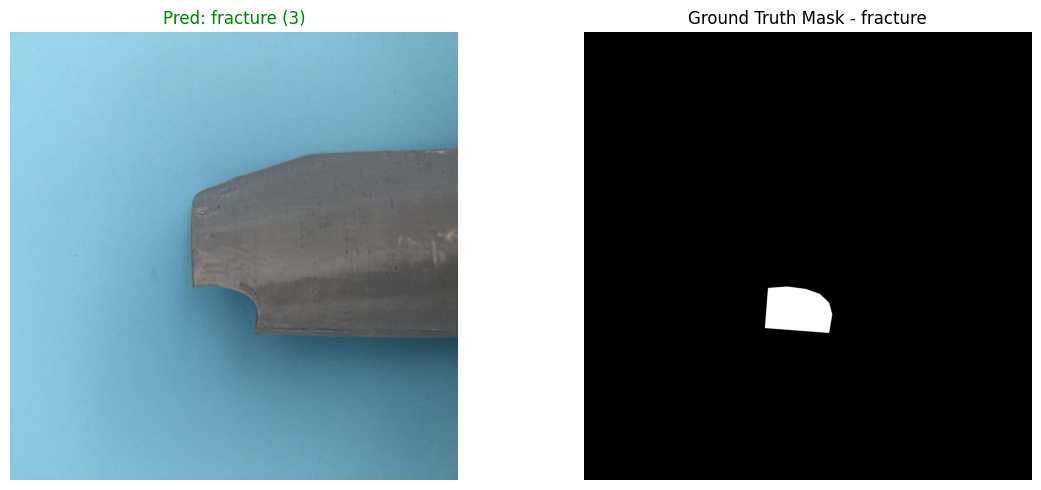

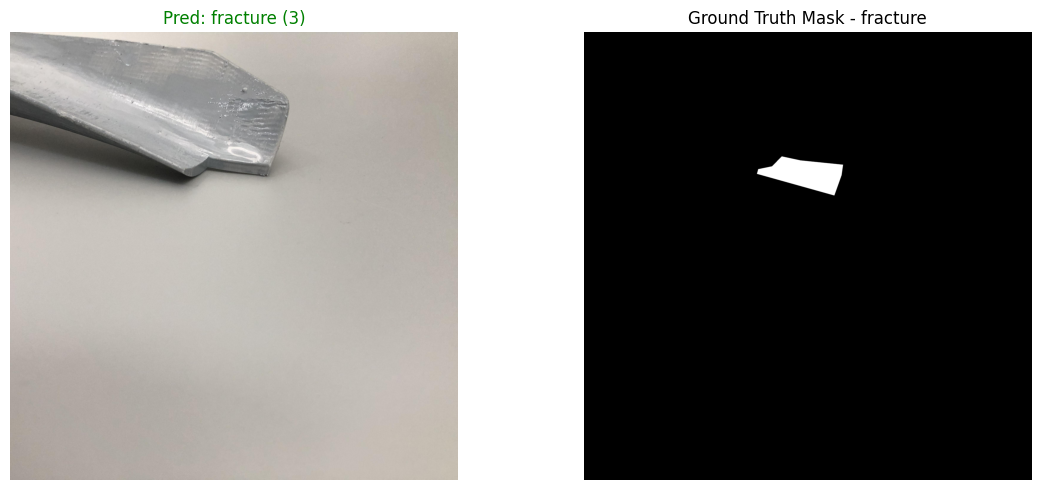

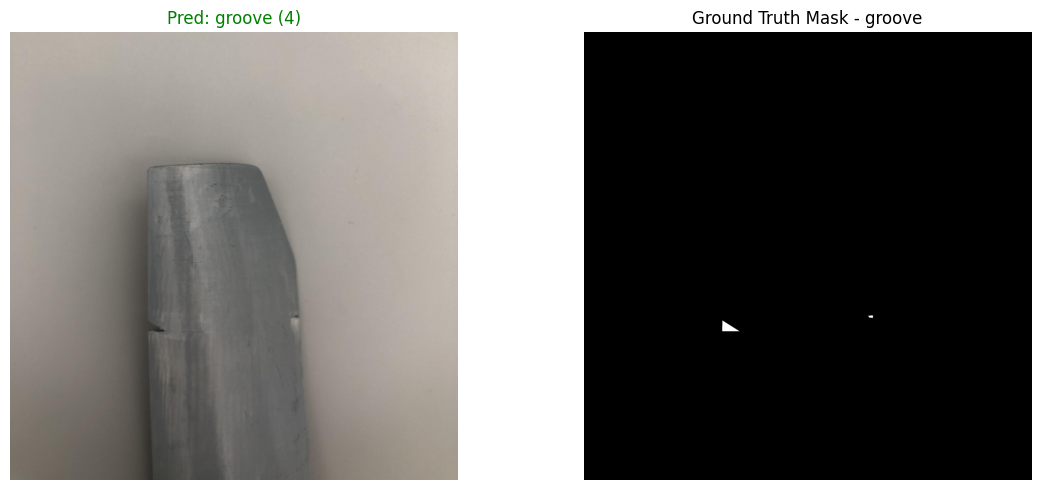

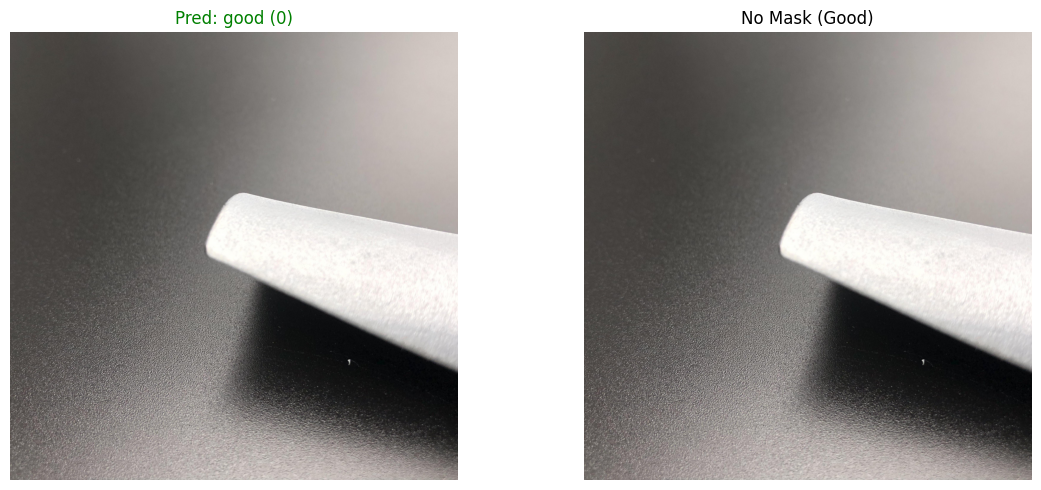

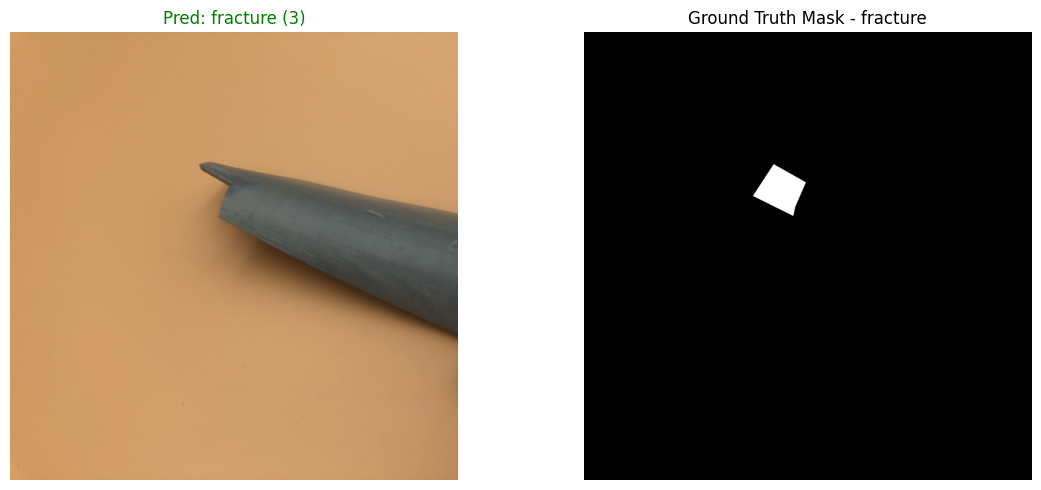

In [12]:
visualize_preds_with_gt_mask(model, image_paths, labels, label_map, device=device, num_samples=5)

# Predict the Class Using Your Trained Model

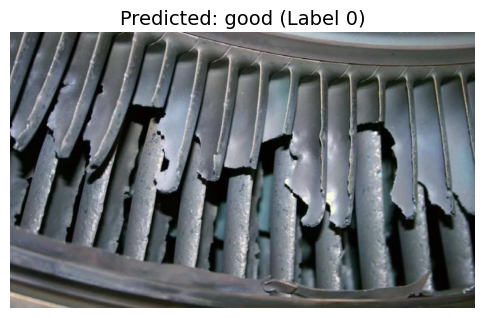

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# ===== 1. Load Image =====
new_img_path = '/kaggle/input/test-img/creep_copy.jpg'  # Replace with your image filename
new_img = Image.open(new_img_path).convert('RGB')

# ===== 2. Transform Image =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # For pre-trained models like VGG
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(new_img).unsqueeze(0).to(device)  # Add batch dimension

# ===== 3. Predict =====
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# ===== 4. Map Label =====
inv_label_map = {v: k for k, v in label_map.items()}
pred_label_name = inv_label_map[pred_class]

# ===== 5. Visualize =====
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
plt.title(f"Predicted: {pred_label_name} (Label {pred_class})", fontsize=14)
plt.axis('off')
plt.show()

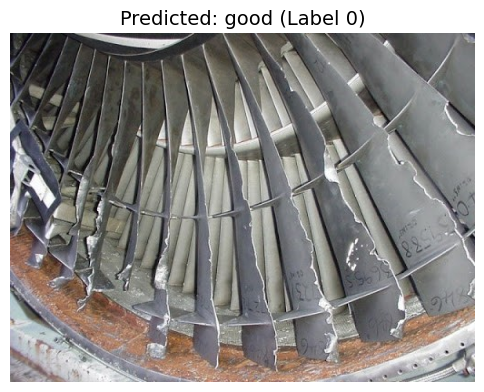

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# ===== 1. Load Image =====
new_img_path = '/kaggle/input/test-img2/1601335618683.jpeg'  # Replace with your image filename
new_img = Image.open(new_img_path).convert('RGB')

# ===== 2. Transform Image =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # For pre-trained models like VGG
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(new_img).unsqueeze(0).to(device)  # Add batch dimension

# ===== 3. Predict =====
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# ===== 4. Map Label =====
inv_label_map = {v: k for k, v in label_map.items()}
pred_label_name = inv_label_map[pred_class]

# ===== 5. Visualize =====
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
plt.title(f"Predicted: {pred_label_name} (Label {pred_class})", fontsize=14)
plt.axis('off')
plt.show()

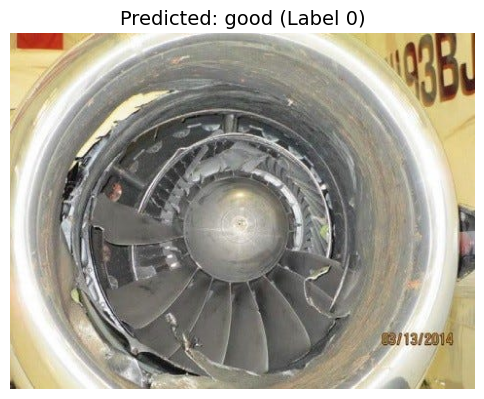

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# ===== 1. Load Image =====
new_img_path = '/kaggle/input/test-img3/gogo.jpg'  # Replace with your image filename
new_img = Image.open(new_img_path).convert('RGB')

# ===== 2. Transform Image =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # For pre-trained models like VGG
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(new_img).unsqueeze(0).to(device)  # Add batch dimension

# ===== 3. Predict =====
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# ===== 4. Map Label =====
inv_label_map = {v: k for k, v in label_map.items()}
pred_label_name = inv_label_map[pred_class]

# ===== 5. Visualize =====
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
plt.title(f"Predicted: {pred_label_name} (Label {pred_class})", fontsize=14)
plt.axis('off')
plt.show()

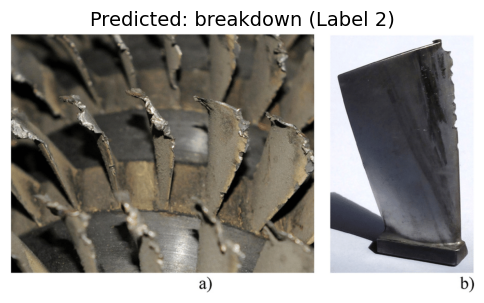

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# ===== 1. Load Image =====
new_img_path = '/kaggle/input/test-img4/Compressor-blades-damaged-by-broken-vanes-of-stator-a-and-the-blade-defected-by-smaller.ppm.png'  # Replace with your image filename
new_img = Image.open(new_img_path).convert('RGB')

# ===== 2. Transform Image =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # For pre-trained models like VGG
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(new_img).unsqueeze(0).to(device)  # Add batch dimension

# ===== 3. Predict =====
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# ===== 4. Map Label =====
inv_label_map = {v: k for k, v in label_map.items()}
pred_label_name = inv_label_map[pred_class]

# ===== 5. Visualize =====
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
plt.title(f"Predicted: {pred_label_name} (Label {pred_class})", fontsize=14)
plt.axis('off')
plt.show()

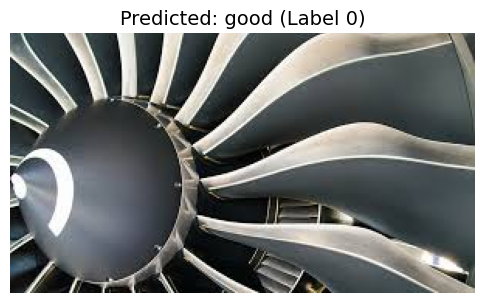

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# ===== 1. Load Image =====
new_img_path = '/kaggle/input/test-img5/images.jpeg'  # Replace with your image filename
new_img = Image.open(new_img_path).convert('RGB')

# ===== 2. Transform Image =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # For pre-trained models like VGG
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(new_img).unsqueeze(0).to(device)  # Add batch dimension

# ===== 3. Predict =====
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# ===== 4. Map Label =====
inv_label_map = {v: k for k, v in label_map.items()}
pred_label_name = inv_label_map[pred_class]

# ===== 5. Visualize =====
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
plt.title(f"Predicted: {pred_label_name} (Label {pred_class})", fontsize=14)
plt.axis('off')
plt.show()